# Solution of Differential Algebraic Equations with Manifold Constraints on the Latent Space of an Autoencoder
## Alejandro Francisco Queiruga

# Equations

The equations
\begin{align}
\partial_t \rho & = \nabla \cdot \mathbf{k}\nabla p + r\\
\partial_t \rho e & = \nabla \cdot \mathbf{k'}\nabla T + s
\end{align}
The typical methodology is to use the empirical relations for density and enthalpy $h$ as a function of pressure and temperature and solve the DAE for $p$ and $T$ implicitly: 
\begin{align}
\text{Solve for}\, p(t)\, \text{and}\, T(t)\, \text{such that:}\\
\partial_t \rho(p,T) & = \nabla \cdot \mathbf{k}\nabla p + r\\
\partial_t \rho e(p,T) & = \nabla \cdot \mathbf{k'}\nabla T + s
\end{align}
The complicatation is that the functions $\rho(p,T)$ and $u(p,T)$ are not well defined functions due to the presence of phase changes that yield sharp discontinuities in $p,T$, as shown in Figure 1 for water. The material can exist on this section of the surface as a mixture of the two phases.

## How do we solve this better?

- Take a step back:
  - Material as a manifold of possible intensive properties
  - How do we represent this manifold?
  - **It's just empirical data**
  - We have observations and expect to stay on these observations.
  - We just need _**any**_ representation of this constraint.

## The Pendulum

The archetypical Constraint Problem: Solve for $x(t),y(t)$ stationary on
\begin{equation}
\mathcal{L}(x,y) = \frac{1}{2}m\left(\dot{x}^2 + \dot{y}^2\right) - m g y
\end{equation}
subject to
\begin{equation}
x^2 + y^2 = R
\end{equation}
The Lagrangian mechanics formulation lets us introduce a parameterization:
\begin{equation}
x = R \cos \theta, \quad y = R \sin \theta
\end{equation}
to plug into the Lagrangian:
\begin{equation}
\mathcal{L}(\theta) = \frac{R^2}{2}\left( \right) \dot{\theta} + g R \sin \theta
\end{equation}

## The Pendulum

The choice of $\theta$ is arbitrary. There are infinimately choices. 

Suppose we only have data:

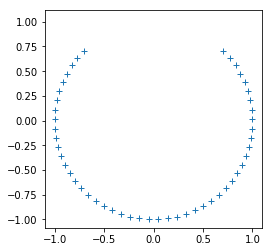

In [9]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
theta = np.linspace(-np.pi*1.25,0.25*np.pi,50, dtype=np.float32)
data = np.vstack([np.cos(theta), np.sin(theta)]).T
plt.plot(data[:,0],data[:,1],'+')
plt.axis('square');

We just need any representation.

## Autoencoders

Put in image comparing arctan and cos sin to an autoencoder

## Solving the Langrangian

Treat the autoencoder the same as $x(\theta)$:
\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}t}
\end{equation}